In [1]:
from conditional_inference.bayes.empirical_bayes import JamesStein, LinearEmpiricalBayes
from conditional_inference.conventional import ConventionalModel

In [2]:
import pandas as pd
import statsmodels.api as sm

<AxesSubplot:title={'center':'Empirical Bayes results'}, xlabel='y'>

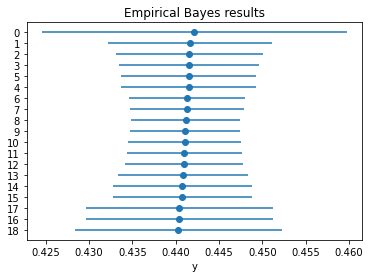

In [70]:
df = pd.read_csv('../data/penn_medicine_reconstructed.csv')
X = pd.get_dummies(df.arm[df.control == 0])
y = df.y[df.control == 0]
ols_results = sm.OLS(y, X).fit().get_robustcov_results()
js_results = JamesStein.from_results(ols_results).fit(cols="sorted")
js_results.point_plot()

In [122]:
tmp_res = sm.OLS(y, np.ones((y.shape[0], 1))).fit()
tmp_res.conf_int()

0         1
const  0.436557  0.445739

In [71]:
import numpy as np

idx = np.argsort(-ols_results.params)
params, cov_params = ols_results.params[idx], ols_results.cov_params()[idx][:, idx]
js_results.score(params, cov_params)

3.3897590301943113e+28

<AxesSubplot:title={'center':'Empirical Bayes results'}, xlabel='y'>

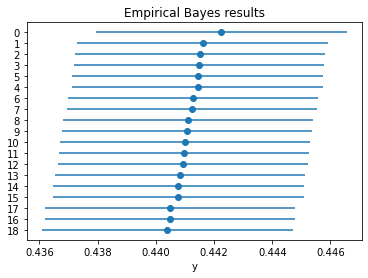

In [72]:
from conditional_inference.bayes.empirical_bayes import LinearEmpiricalBayes

eb_results = LinearEmpiricalBayes.from_results(ols_results).fit(cols="sorted")
eb_results.point_plot()

In [73]:
eb_results.score(params, cov_params)

7.388889077426136e+26

<AxesSubplot:title={'center':'Hierarchical Bayes results'}, xlabel='y'>

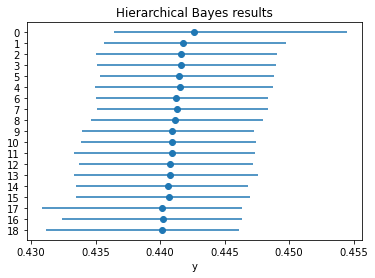

In [84]:
from conditional_inference.bayes.hierarchical_bayes import LinearHierarchicalBayes

from scipy.stats import loguniform

hb_results = LinearHierarchicalBayes.from_results(ols_results, prior_cov_params_distribution=loguniform(1e-7, 1e-4)).fit(cols="sorted")
hb_results.point_plot()

In [85]:
hb_results.score(params, cov_params)

1.0635502296742903e+27

In [86]:
conventional_results = ConventionalModel.from_results(ols_results).fit(cols="sorted")
conventional_results.point_plot()

<AxesSubplot:title={'center':'Conventional results'}, xlabel='y'>

In [87]:
conventional_results.score(params, cov_params)

1.932492264659164e+27

In [88]:
from sklearn.model_selection import StratifiedKFold

def compute_result(idx):
    return sm.OLS(y.values[idx], X.values[idx]).fit().get_robustcov_results()

train_results = []
test_results = []
kf = StratifiedKFold(5, shuffle=True)
for train_idx, test_idx in kf.split(X, df.arm[df.control==0]):
    train_results.append(compute_result(train_idx))
    test_results.append(compute_result(test_idx))

In [109]:
models = [ConventionalModel, JamesStein, LinearEmpiricalBayes, LinearHierarchicalBayes]
for model in models:
    kwargs = dict()
    if model == LinearHierarchicalBayes:
        kwargs = dict(prior_cov_params_distribution=loguniform(1e-11, 1e-10))
    score = []
    for train_res, test_res in zip(train_results, test_results):
        result = model.from_results(train_res, **kwargs).fit()
        score.append(result.score(test_res.params, test_res.cov_params()))
    print(model.__name__, np.mean(score))

ConventionalModel 4.760623993320602e+19
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\bayes\empirical_bayes.py:170: RuntimeWarning: The prior variance parameter given by the James-Stein estimator 0.00011900742051415364 implies the prior covariance matrix is not positive semi-definite. Increasing the prior variance parameter to 0.0001316070556640625.
  warnings.warn(
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\bayes\empirical_bayes.py:170: RuntimeWarning: The prior variance parameter given by the James-Stein estimator 0.0001304316035777352 implies the prior covariance matrix is not positive semi-definite. Increasing the prior variance parameter to 0.0001316070556640625.
  warnings.warn(
JamesStein 3.5095919148742515e+20
LinearEmpiricalBayes 5.4741940625196574e+20
LinearHierarchicalBayes 5.814129925003478e+20


In [91]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform

def cv_score(power, power_diff):
    dist = loguniform(10**power, 10**(power+power_diff))
    score = []
    for train_res, test_res in zip(train_results, test_results):
        result = LinearHierarchicalBayes.from_results(
            train_res,
            prior_cov_params_distribution=dist
        ).fit()
        score.append(result.score(test_res.params, test_res.cov_params()))
    print(power, power_diff, np.mean(score))
    return np.mean(score)

sampler = list(ParameterSampler(
    dict(
        power=uniform(-9, 4),
        power_diff=uniform(.5, 3)
    ),
    n_iter=10
))
scores = [cv_score(**params) for params in sampler]

-5.391094568162497 1.6177758907485436 4.4369394347007214e+20
-7.991617502192924 1.9617953339630387 5.8267874222433986e+20
-7.362134788367472 3.1360736024931426 5.384996845954393e+20
-7.4382906136417795 1.1238800600391183 5.8106585665414155e+20
-7.228277360637111 2.0217647843864306 5.677315847022277e+20
-6.776484439206108 1.09489142868052 5.727384352763406e+20
-8.613462610452462 2.912088919354324 5.758138128567672e+20
-7.781859714343632 2.4731772208575236 5.753702143296362e+20
-8.117789203595052 3.38054634460965 5.644304862549784e+20
-7.977793789160424 2.968747836477201 5.7186966420102316e+20


In [92]:
best_params = sampler[np.argmax(score)]
best_params

{'power': -7.228277360637111, 'power_diff': 2.0217647843864306}

(0.4, 0.5)

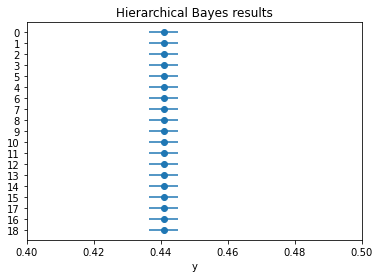

In [108]:
dist = loguniform(10**best_params["power"], 10**(best_params["power"]+best_params["power_diff"]))
dist = loguniform(1e-11, 1e-10)
hb_results = LinearHierarchicalBayes.from_results(ols_results, prior_cov_params_distribution=dist).fit(cols="sorted")
ax = hb_results.point_plot()
ax.set_xlim((.4, .5))

In [123]:
hb_results.conf_int()

array([[0.43652238, 0.44506533],
       [0.43652037, 0.44507038],
       [0.43652146, 0.44507499],
       [0.43651995, 0.44507119],
       [0.43651862, 0.44506912],
       [0.43651378, 0.44507284],
       [0.43652136, 0.44506373],
       [0.4365207 , 0.44507706],
       [0.43651547, 0.44507372],
       [0.43652395, 0.44507028],
       [0.436517  , 0.44506817],
       [0.4365207 , 0.44507801],
       [0.43652309, 0.44507238],
       [0.43651772, 0.44507395],
       [0.43651723, 0.44507053],
       [0.43652104, 0.44507575],
       [0.43652089, 0.44506579],
       [0.43652388, 0.44506432],
       [0.43652434, 0.44507384]])

In [96]:
from conditional_inference.utils import ranked_mean_squared_error

ranked_mean_squared_error(params, cov_params, hb_results.param_rvs, hb_results.sample_weight)

2.254899519815982e-05

In [97]:
ranked_mean_squared_error(params, cov_params, js_results.param_rvs)

2.4317483767332452e-05

In [98]:
ranked_mean_squared_error(params, cov_params, conventional_results.param_rvs)

8.587351883357251e-05

In [106]:
ranked_mean_squared_error(params, cov_params, np.full((1, params.shape[0]), params.mean()))

7.826440500148737e-06